### mm_fooof

This notebook runs fooof analyses on cluster data. It uses functions from mm_loadData. Goal is to ask the following questions

* Regarding the movement cluster:
    * focus on two time windows - pre-movement (-800:400) and post-movement (400:1200)
    * Are there narrowband oscillations prior to movement? If so which ones? A: theta, beta
    * How does the power spectrum change during movement? A: Decrease in slope, minimal change in oscillations
    * Are the low frequency power decreases seen related to slope or decreased oscillations? 
* Regarding instruction cluster:
    * focus on two time windows - pre-instruction (-800:400) and post-instruction (400:1200)
    * Same as above
* Comparing movement and instruction cluster?
    * Focus on pre-movement (-800:400)
    * How do oscillatory components differ between the two clusters - may provide insight in how oscillations at different frequencies support sensory and motor processing
    
To DO:

[x] compare clus 3 pre-move and post-move
[x] compare clus 1 pre-inst and post-inst
[x] compare clus 3 and clus 1
[x] stats
[x] figures
[x] convert in to class related functins




In [4]:
# import packages
import numpy as np # numpy
import pandas as pd # pandas
from scipy import stats
import mm_func
import mne
import pycircstat as circ
from mne import time_frequency
from fooof import FOOOF
from pylab import * 
%matplotlib inline
import os

In [16]:
# set params
# define parameters for analyses as a dictionary
params = {'clusId':3,'rejection_thresh_sd':20,
          'event_type':'move',
          'time_window_ms':(-500,1000),
          'time_window_ms_pre':(-1200,0),
          'time_window_ms_pst':(0,1200),
          'buffer_ms':0,
         'frange':(2,40),
         'bg_param':'knee',
          'HFA_range':(70,120),
          'theta_range':(3,8),
          'alpha_range':(10,12),
          'beta_range':(12,30),
          'gamma_range':(30,40)} 
# fig path
figpath = '/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/motormap/figs/fooofFits/'
print(figpath)

# make directory if it doesnt exist
if os.path.exists(figpath) == False:
    os.makedirs(figpath)

/Users/ashwinramayya/Dropbox/neurosurgery_research/jupyter/motormap/figs/fooofFits/


In [267]:
class fooofGroup:
    # This class collects fooof fit results for a group of electrodes
    
    def __init__(self,groupLbl,EEG,metadata):
        
        # label this electrode group
        self.groupLbl = groupLbl
        self.EEG = EEG
        self.metadata = metadata
        
        #containers
        self.aperiodic = np.array(empty)
        self.theta =  np.array(empty)
        self.alpha =  np.array(empty)
        self.beta =  np.array(empty)
        self.gamma =  np.array(empty)
        self.r_sq =  np.array(empty)
        self.fit_error =  np.array(empty)
    
    #This function runs through contacts in a given cluster and time window and collects fooof fits
    def collectFits(self,event_type,time_window_ms,params):
        """ this function loops through all electrodes in the electrode group. It 
        uses the mm_func.Electrode class to fit FOOOF to specific EEG clip and collects parameters in self
        
        # Inputs
        event_type = 'move' vs 'inst' vs 'wait'
        time_window_ms = (-1000,200), time window to perform fit
        params - dictionary that must contain the following 
        
        params = {'buffer_ms':0, # buffer to include
        'rejection_thresh_sd':20} # threshold to use when rejecting single trials with noisy data
        """

        # parse params
        buffer_ms = params['buffer_ms']
        rejection_thresh_sd = params['rejection_thresh_sd']
        

        # initialize arrays to store data
        theta_peaks = np.empty([len(self.EEG),3])
        theta_peaks[:] = np.nan

        beta_peaks = theta_peaks.copy()
        alpha_peaks = theta_peaks.copy()
        gamma_peaks = theta_peaks.copy()
        aperiodic_params = theta_peaks.copy()
        
        r_sq_vec = np.empty([len(self.EEG),1])
        fit_error_vec = np.empty([len(self.EEG),1])

        for c in arange(0,len(self.EEG)):
            
            # instantiate Electrode
            E = mm_func.Electrode(self.EEG[c],self.metadata[c:c+1])
            
            # get eeg clip
            E.getEEG(event_type,time_window_ms,buffer_ms,rejection_thresh_sd)
            
            # calculate PSD for eeg_clip above
            E.calcPSD(params['frange'])
            
            # fit FOOOF
            E.fitFOOOF(bg_param = params['bg_param'],
                       theta_range = params['theta_range'],
                       alpha_range = params['alpha_range'],
                       beta_range = params['beta_range'],
                      gamma_range = params['gamma_range'])

            # collect data
            aperiodic_params[c,:] = E.aperiodic
            theta_peaks[c,:] = E.theta
            alpha_peaks[c,:] = E.alpha
            beta_peaks[c,:] = E.beta
            gamma_peaks[c,:] = E.gamma
            r_sq_vec[c] =  E.r_sq
            fit_error_vec[c] = E.fit_error
                    
        # update self
        self.aperiodic = aperiodic_params
        self.theta = theta_peaks
        self.alpha = alpha_peaks
        self.beta = beta_peaks
        self.gamma = gamma_peaks
        self.r_sq = r_sq_vec
        self.fit_error = fit_error_vec
        
        # calculate counts
        self.theta_count =sum(np.isnan(self.theta[:,0])==False)
        self.beta_count =sum(np.isnan(self.beta[:,0])==False)
        self.alpha_count =sum(np.isnan(self.alpha[:,0])==False)
        self.gamma_count =sum(np.isnan(self.gamma[:,0])==False)
        
        
        # for tracking parameters
        self.event_type = event_type
        self.time_window_ms = time_window_ms
        self.clusId = self.metadata.clusId[0]
        self.bg_params = params['bg_param']
        self.theta_range = params['theta_range']
        self.alpha_range = params['alpha_range']
        self.beta_range = params['beta_range']
        self.gamma_range = params['gamma_range']
                
        
    def plot_aperiodic_slope(self,ax=None,xval=1,kol='blue'):
        """This function plots an error bar of the aperiodic slope. 
        Inputs:
        xval - marks the x-value to plot the error bar
        kol - color to use"""
        if ax == None:
            fig = figure()
            ax = subplot(111)
        
        # plot mean and SD of slope pre
        mean_slope = self.aperiodic[:,0].mean()
        sem_slope = stats.sem(self.aperiodic[:,0])
        bar(xval,mean_slope,color = kol)
        errorbar(xval,mean_slope,sem_slope,color = 'black')
    def plot_narrowband_amp(self,ax=None,label='theta',xval=1,kol='blue'):
        """This function plots an error bar of the aperiodic slope. 
        Inputs:
        xval - marks the x-value to plot the error bar
        kol - color to use"""
        if ax == None:
            fig = figure()
            ax = subplot(111)
        if label=='theta':
            nb = self.theta[:,1]
        elif label=='alpha':
            nb = self.alpha[:,1]
        elif label=='beta':
            nb = self.beta[:,1]
        elif label=='gamma':
            nb = self.gamma[:,1]    
        
        # plot mean and SD of slope pre
        mean_slope = np.nanmean(nb)
        sem_slope = stats.sem(nb,nan_policy = 'omit')
        bar(xval,mean_slope,color = kol)
        errorbar(xval,mean_slope,sem_slope,color = 'black')
    
    
    def plot_peak_counts(self,ax = None):
        """This plots a bar graph counting the number of electrodes in the group with a peak 
        in each of the narrowbands """
        if ax == None:
            fig = figure()
            ax = subplot(111)
            
        # plot bar
        bar([0,1,2,3],[self.theta_count,self.alpha_count,self.beta_count,self.gamma_count])
        ylabel('count')
        xticks([0,1,2,3],['theta','alpha','beta','gamma'])
        ax.set_title('Clus '+str(self.clusId)+' peaks: '+str(self.time_window_ms)+'  '+self.event_type)

    def stats_chisq_narrowbandPeaks(self,other):
        """computes chisq test comparing rates of narrowband peaks in this object vs. another"""
        obs = [self.theta_count,self.alpha_count,self.beta_count,self.gamma_count]
        exp = [other.theta_count,other.alpha_count,other.beta_count,other.gamma_count]
        chisq, p = stats.chisquare(obs,exp)
        return [chisq,p]
        
        
        
    

In [17]:
#load data from Cluster 3
[EEG_c3,metadata_c3] = mm_func.loadEEG(clusId=3)

#load data from Cluster 1
[EEG_c1,metadata_c1] = mm_func.loadEEG(clusId=1)

/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/
/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/pacClusStruct-3.mat
dict_keys(['__header__', '__version__', '__globals__', 'eegStruct_thisClus'])
Number of contacts in Cluster 3 = 46
REPLACING Contact 13 field anat with NONE
Done loading Cluster 3
/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/
/Users/ashwinramayya/Dropbox/neurosurgery_research/data/scratch/clusStruct/pac/pacClusStruct-1.mat
dict_keys(['__header__', '__version__', '__globals__', 'eegStruct_thisClus'])
Number of contacts in Cluster 1 = 38
REPLACING Contact 0 field anat with NONE
REPLACING Contact 1 field anat with NONE
REPLACING Contact 10 field anat with NONE
REPLACING Contact 13 field anat with NONE
REPLACING Contact 31 field anat with NONE
Done loading Cluster 1


In [268]:
%%capture
#Initialize 
C3_m_pre = fooofGroup('cluster3_move_pre',EEG_c3,metadata_c3)
C3_m_pre.collectFits('move',params['time_window_ms_pre'],params)

C3_m_post = fooofGroup('cluster3_move_post',EEG_c3,metadata_c3)
C3_m_post.collectFits('move',params['time_window_ms_pst'],params)

C1_i_pre = fooofGroup('cluster1_inst_pre',EEG_c1,metadata_c1)
C1_i_pre.collectFits('inst',params['time_window_ms_pre'],params)

C1_i_post = fooofGroup('cluster1_inst_post',EEG_c1,metadata_c1)
C1_i_post.collectFits('inst',params['time_window_ms_pst'],params)

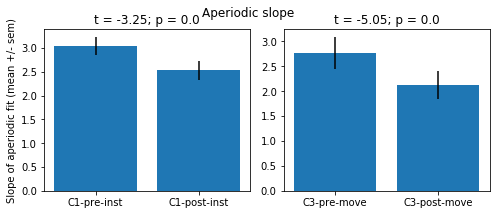

In [269]:
# plot aperiodic slopes for all 4 conditions
fig = figure(figsize=[7,3])
fig.suptitle('Aperiodic slope')
C = cm.get_cmap('tab10')
C.colors[0]

# C1, Inst PRE- vs. Post - 
ax = subplot(121)
C1_i_pre.plot_aperiodic_slope(ax,xval =1,kol=C.colors[0])
C1_i_post.plot_aperiodic_slope(ax,xval =2,kol=C.colors[0])
[t,p] = stats.ttest_rel(C1_i_post.aperiodic[:,0],C1_i_pre.aperiodic[:,0])
ax.set_title('t = '+str(np.around(t,decimals=2))+'; p = '+str(np.around(p,decimals=2)))
ylabel('Slope of aperiodic fit (mean +/- sem)')
xticks([1,2],['C1-pre-inst','C1-post-inst'])
ax.set_xlim([0.5,2.5])

# C3, move PRE- vs. Post - 
ax = subplot(122)
C3_m_pre.plot_aperiodic_slope(ax,xval =1,kol=C.colors[0])
C3_m_post.plot_aperiodic_slope(ax,xval =2,kol=C.colors[0])
[t,p] = stats.ttest_rel(C3_m_post.aperiodic[:,0],C3_m_pre.aperiodic[:,0])
ax.set_title('t = '+str(np.around(t,decimals=2))+'; p = '+str(np.around(p,decimals=2)))
# set xticks
xticks([1,2],['C3-pre-move','C3-post-move'])
ax.set_xlim([0.5,2.5])

tight_layout()

cluster 1 pre vs post instruction: 
 chisq 1.64 p 0.65
cluster 3 pre vs post move: 
 chisq 3.68 p 0.3
cluster 1 pre inst vs clus 3 pre move: 
 chisq inf p 0.0
cluster 1 post inst vs clus 3 post move: 
 chisq 5.85 p 0.12


/Users/ashwinramayya/anaconda3/envs/environment_name/lib/python3.7/site-packages/scipy/stats/stats.py:5048: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


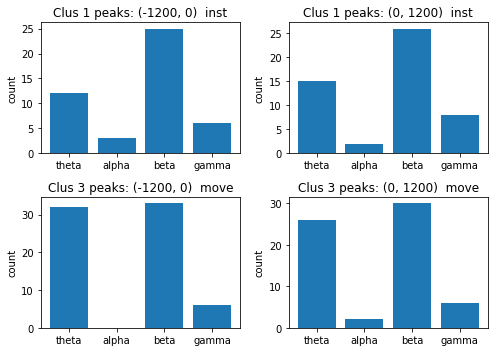

In [270]:
# plot summary of narrow band peaks
fig = figure(figsize=[7,5])

# C1 Pre Inst
C1_i_pre.plot_peak_counts(subplot(221))

# C1 Post Inst
C1_i_post.plot_peak_counts(subplot(222))

# C3 Pre Move
C3_m_pre.plot_peak_counts(subplot(223))

# C3 Post Move
C3_m_post.plot_peak_counts(subplot(224))

tight_layout()


# Do stats:

# chi sq test comparing cluster 1 pre and post instruction
chisq, p = C1_i_pre.stats_chisq_narrowbandPeaks(C1_i_post)
print('cluster 1 pre vs post instruction: \n','chisq '+str(np.around(chisq,decimals=2))+' p '+str(np.around(p,decimals=2)))

# chi sq test comparing cluster 3 pre and post distributions 
chisq, p = C3_m_pre.stats_chisq_narrowbandPeaks(C3_m_post)
print('cluster 3 pre vs post move: \n','chisq '+str(np.around(chisq,decimals=2))+' p '+str(np.around(p,decimals=2)))


# chi sq test comparing cluster 1 pre inst vs cluster 3 pre move
chisq, p = C1_i_pre.stats_chisq_narrowbandPeaks(C3_m_pre)
print('cluster 1 pre inst vs clus 3 pre move: \n','chisq '+str(np.around(chisq,decimals=2))+' p '+str(np.around(p,decimals=2)))

# chi sq test comparing cluster 1 post inst vs cluster 3 post move
chisq, p = C1_i_post.stats_chisq_narrowbandPeaks(C3_m_post)
print('cluster 1 post inst vs clus 3 post move: \n','chisq '+str(np.around(chisq,decimals=2))+' p '+str(np.around(p,decimals=2)))

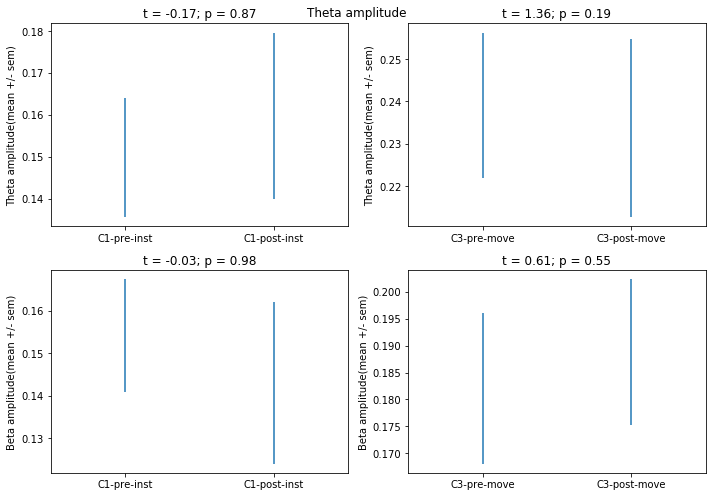

In [255]:
# Plot peak counts in various bands. model after this code, but make it a class based function,

fig = figure(figsize=[10,7])
fig.suptitle('Theta amplitude')
C = cm.get_cmap('tab10')
C.colors[0]

# Theta 
ax = subplot(221)
C1_i_pre.plot_narrowband_amp(ax,'theta',xval =1,kol=C.colors[0])
C1_i_post.plot_narrowband_amp(ax,'theta',xval =2,kol=C.colors[0])
[t,p] = stats.ttest_rel(C1_i_pre.theta[:,1],C1_i_post.theta[:,1],nan_policy = 'omit')
ax.set_title('t = '+str(np.around(t,decimals=2))+'; p = '+str(np.around(p,decimals=2)))
ylabel('Theta amplitude(mean +/- sem)')
xticks([1,2],['C1-pre-inst','C1-post-inst'])
ax.set_xlim([0.5,2.5])

ax = subplot(222)
C3_m_pre.plot_narrowband_amp(ax,'theta',xval =1,kol=C.colors[0])
C3_m_post.plot_narrowband_amp(ax,'theta',xval =2,kol=C.colors[0])
[t,p] = stats.ttest_rel(C3_m_pre.theta[:,1],C3_m_post.theta[:,1],nan_policy = 'omit')
ax.set_title('t = '+str(np.around(t,decimals=2))+'; p = '+str(np.around(p,decimals=2)))
ylabel('Theta amplitude(mean +/- sem)')
xticks([1,2],['C3-pre-move','C3-post-move'])
ax.set_xlim([0.5,2.5])


# beta 
ax = subplot(223)
C1_i_pre.plot_narrowband_amp(ax,'beta',xval =1,kol=C.colors[0])
C1_i_post.plot_narrowband_amp(ax,'beta',xval =2,kol=C.colors[0])
[t,p] = stats.ttest_rel(C1_i_pre.beta[:,1],C1_i_post.beta[:,1],nan_policy = 'omit')
ax.set_title('t = '+str(np.around(t,decimals=2))+'; p = '+str(np.around(p,decimals=2)))
ylabel('Beta amplitude(mean +/- sem)')
xticks([1,2],['C1-pre-inst','C1-post-inst'])
ax.set_xlim([0.5,2.5])

ax = subplot(224)
C3_m_pre.plot_narrowband_amp(ax,'beta',xval =1,kol=C.colors[0])
C3_m_post.plot_narrowband_amp(ax,'beta',xval =2,kol=C.colors[0])
[t,p] = stats.ttest_rel(C3_m_pre.beta[:,1],C3_m_post.beta[:,1],nan_policy = 'omit')
ax.set_title('t = '+str(np.around(t,decimals=2))+'; p = '+str(np.around(p,decimals=2)))
ylabel('Beta amplitude(mean +/- sem)')
xticks([1,2],['C3-pre-move','C3-post-move'])
ax.set_xlim([0.5,2.5])

tight_layout()